In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import spearmanr

from tqdm import trange

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch #https://github.com/facebookresearch/esm
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


### Loading interaction df

In [2]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

# Adding new target id
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}

for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1

interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

binder_id target_id  \
0             EHEE_rd4_0110_min_rise1_21_000000015_0001     VirB8   
1             Grafting_Motif0040_ems_3hM_3083_0001_0002     FGFR2   
2                   Grafting_Motif0042_ems_3hM_148_0001     FGFR2   
3                  Grafting_Motif0042_ems_3hM_1661_0001     FGFR2   
4                   Grafting_Motif0042_ems_3hM_257_0001     FGFR2   
...                                                 ...       ...   
3527  il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...     IL2Ra   
3528  il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...     IL2Ra   
3529  il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...     IL2Ra   
3530  il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...     IL2Ra   
3531  il2ra_site1_2b5i_sap_8_mot_HHH_b2_07920_000000...     IL2Ra   

     binder_chain target_chains binder  \
0               A         ["B"]  False   
1               A         ["B"]  False   
2               A         ["B"]  False   
3               A         ["B"]  False   
4               A         ["B"]  False   
...           ...           ...    ...   
3527            A         ["B"]  False   
3528            A         ["B"]  False   
3529            A         ["B"]  False   
3530            A         ["B"]  False   
3531            A         ["B"]  False   

                                                  A_seq  \
0              LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK   
1     SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...   
2     DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...   
3     DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...   
4     PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...   
...                                                 ...   
3527  DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...   
3528  SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...   
3529  SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...   
3530  DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...   
3531  SEAARRARELFHEADELDKRGNPEEAEEVLREALELAREAGSPNLA...   

                                                  B_seq target_id_mod  \
0     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...         VirB8   
1     RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...         FGFR2   
2     RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...         FGFR2   
3     RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...         FGFR2   
4     RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...         FGFR2   
...                                                 ...           ...   
3527  ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...         IL2Ra   
3528  ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...         IL2Ra   
3529  ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...         IL2Ra   
3530  ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...         IL2Ra   
3531  ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...         IL2Ra   

     target_binder_ID  
0             VirB8_1  
1             FGFR2_1  
2             FGFR2_2  
3             FGFR2_3  
4             FGFR2_4  
...               ...  
3527         IL2Ra_62  
3528         IL2Ra_63  
3529         IL2Ra_64  
3530         IL2Ra_65  
3531         IL2Ra_66  

[3532 rows x 9 columns]

### Loading p @ Ls (cutoff = 8A, minimal sequence separation = 6)

In [3]:
patLs_df = pd.read_csv("/work3/s232958/data/meta_analysis/binder_p_at_Ls_thres8_6.csv")
patLs_df

binder_id  contact_map  head1  head2  head3  head4  head5  head6  head7  \
0      VirB8_1        0.700  0.075  0.125  0.125  0.125  0.075  0.025  0.300   
1      FGFR2_1        0.371  0.016  0.065  0.016  0.129  0.032  0.048  0.145   
2      FGFR2_2        0.623  0.033  0.115  0.049  0.131  0.115  0.016  0.213   
3      FGFR2_3        0.594  0.016  0.062  0.078  0.109  0.141  0.016  0.188   
4      FGFR2_4        0.297  0.031  0.078  0.062  0.109  0.078  0.000  0.062   
...        ...          ...    ...    ...    ...    ...    ...    ...    ...   
3527  IL2Ra_62        0.473  0.018  0.000  0.036  0.036  0.073  0.018  0.055   
3528  IL2Ra_63        0.429  0.000  0.018  0.089  0.018  0.071  0.000  0.071   
3529  IL2Ra_64        0.536  0.054  0.071  0.054  0.125  0.125  0.018  0.161   
3530  IL2Ra_65        0.351  0.000  0.105  0.053  0.175  0.105  0.018  0.053   
3531  IL2Ra_66        0.649  0.105  0.053  0.053  0.211  0.158  0.018  0.246   

      head8  ...  head11  head12  head13  head14  head15  head16  head17  \
0     0.075  ...   0.300   0.300   0.375   0.575   0.175   0.200   0.125   
1     0.065  ...   0.113   0.065   0.145   0.355   0.097   0.016   0.048   
2     0.115  ...   0.180   0.148   0.361   0.443   0.115   0.049   0.098   
3     0.125  ...   0.141   0.094   0.188   0.578   0.141   0.016   0.141   
4     0.062  ...   0.031   0.031   0.156   0.188   0.094   0.000   0.016   
...     ...  ...     ...     ...     ...     ...     ...     ...     ...   
3527  0.055  ...   0.073   0.091   0.109   0.418   0.000   0.018   0.036   
3528  0.161  ...   0.054   0.054   0.161   0.321   0.071   0.000   0.000   
3529  0.196  ...   0.196   0.089   0.232   0.339   0.107   0.036   0.161   
3530  0.053  ...   0.140   0.123   0.140   0.333   0.000   0.018   0.070   
3531  0.228  ...   0.175   0.123   0.228   0.509   0.175   0.018   0.123   

      head18  head19  head20  
0      0.150   0.300   0.125  
1      0.032   0.226   0.097  
2      0.049   0.492   0.131  
3      0.016   0.453   0.125  
4      0.016   0.219   0.094  
...      ...     ...     ...  
3527   0.000   0.327   0.145  
3528   0.000   0.304   0.036  
3529   0.107   0.464   0.018  
3530   0.018   0.316   0.140  
3531   0.070   0.561   0.070  

[3532 rows x 22 columns]

### Loading average log-likelihood / pseudo-perplexity

In [4]:
averageLL_pPLL_df = pd.read_csv("/work3/s232958/data/meta_analysis/averageLL_pPLL.csv").drop(columns= ["binder_id"]).rename(columns = {"target_binder_ID" : "binder_id"})
averageLL_pPLL_df

binder_id                                         seq_binder  \
0      VirB8_1           LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK   
1      FGFR2_1  SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...   
2      FGFR2_2  DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...   
3      FGFR2_3  DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...   
4      FGFR2_4  PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...   
...        ...                                                ...   
3527  IL2Ra_62  DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...   
3528  IL2Ra_63  SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...   
3529  IL2Ra_64  SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...   
3530  IL2Ra_65  DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...   
3531  IL2Ra_66  SEAARRARELFHEADELDKRGNPEEAEEVLREALELAREAGSPNLA...   

      avg_log_likelihood  pseudo_perplexity  
0              -2.749460          15.634179  
1              -2.732485          15.371030  
2              -2.527573          12.523080  
3              -2.289752           9.872489  
4              -2.577624          13.165817  
...                  ...                ...  
3527           -2.042634           7.710890  
3528           -1.827751           6.219881  
3529           -1.441779           4.228210  
3530           -2.069157           7.918145  
3531           -1.803822           6.072814  

[3532 rows x 4 columns]

In [5]:
final_df = pd.merge(
    averageLL_pPLL_df[["binder_id", "seq_binder", "avg_log_likelihood", "pseudo_perplexity"]],
    patLs_df,
    on="binder_id",
    how="inner"
)
final_df

binder_id                                         seq_binder  \
0      VirB8_1           LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK   
1      FGFR2_1  SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...   
2      FGFR2_2  DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...   
3      FGFR2_3  DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...   
4      FGFR2_4  PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...   
...        ...                                                ...   
3527  IL2Ra_62  DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...   
3528  IL2Ra_63  SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...   
3529  IL2Ra_64  SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...   
3530  IL2Ra_65  DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...   
3531  IL2Ra_66  SEAARRARELFHEADELDKRGNPEEAEEVLREALELAREAGSPNLA...   

      avg_log_likelihood  pseudo_perplexity  contact_map  head1  head2  head3  \
0              -2.749460          15.634179        0.700  0.075  0.125  0.125   
1              -2.732485          15.371030        0.371  0.016  0.065  0.016   
2              -2.527573          12.523080        0.623  0.033  0.115  0.049   
3              -2.289752           9.872489        0.594  0.016  0.062  0.078   
4              -2.577624          13.165817        0.297  0.031  0.078  0.062   
...                  ...                ...          ...    ...    ...    ...   
3527           -2.042634           7.710890        0.473  0.018  0.000  0.036   
3528           -1.827751           6.219881        0.429  0.000  0.018  0.089   
3529           -1.441779           4.228210        0.536  0.054  0.071  0.054   
3530           -2.069157           7.918145        0.351  0.000  0.105  0.053   
3531           -1.803822           6.072814        0.649  0.105  0.053  0.053   

      head4  head5  ...  head11  head12  head13  head14  head15  head16  \
0     0.125  0.075  ...   0.300   0.300   0.375   0.575   0.175   0.200   
1     0.129  0.032  ...   0.113   0.065   0.145   0.355   0.097   0.016   
2     0.131  0.115  ...   0.180   0.148   0.361   0.443   0.115   0.049   
3     0.109  0.141  ...   0.141   0.094   0.188   0.578   0.141   0.016   
4     0.109  0.078  ...   0.031   0.031   0.156   0.188   0.094   0.000   
...     ...    ...  ...     ...     ...     ...     ...     ...     ...   
3527  0.036  0.073  ...   0.073   0.091   0.109   0.418   0.000   0.018   
3528  0.018  0.071  ...   0.054   0.054   0.161   0.321   0.071   0.000   
3529  0.125  0.125  ...   0.196   0.089   0.232   0.339   0.107   0.036   
3530  0.175  0.105  ...   0.140   0.123   0.140   0.333   0.000   0.018   
3531  0.211  0.158  ...   0.175   0.123   0.228   0.509   0.175   0.018   

      head17  head18  head19  head20  
0      0.125   0.150   0.300   0.125  
1      0.048   0.032   0.226   0.097  
2      0.098   0.049   0.492   0.131  
3      0.141   0.016   0.453   0.125  
4      0.016   0.016   0.219   0.094  
...      ...     ...     ...     ...  
3527   0.036   0.000   0.327   0.145  
3528   0.000   0.000   0.304   0.036  
3529   0.161   0.107   0.464   0.018  
3530   0.070   0.018   0.316   0.140  
3531   0.123   0.070   0.561   0.070  

[3532 rows x 25 columns]

### Plotting:
- contact heads p@L vs attention p@L
- p@L vs PLL

### contact heads p@L vs attention p@L

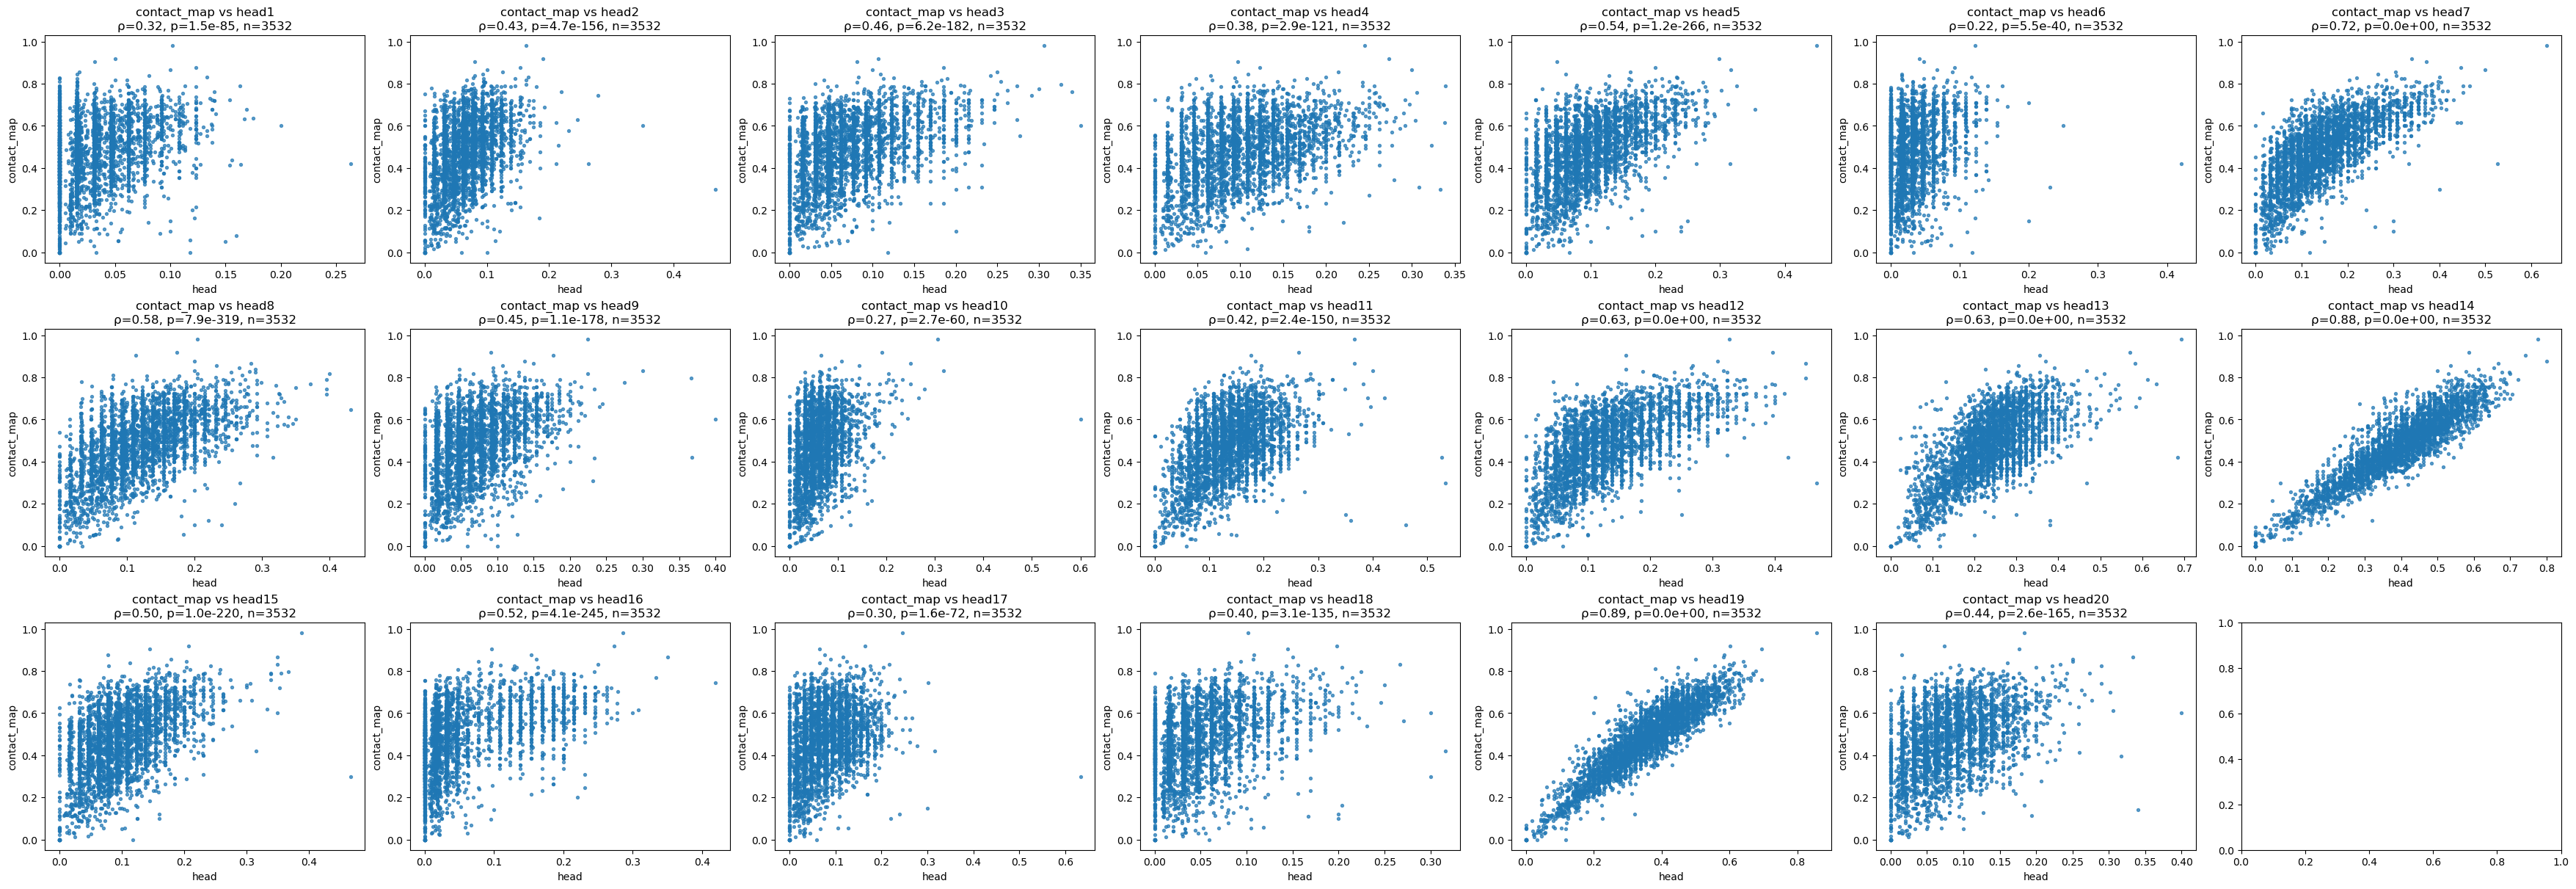

In [8]:
heads_list = [f"head{i}" for i in range(1, 21)]
nplots = len(heads_list)
ncols = 7
nrows = ceil(nplots / ncols) # 5

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, head in zip(axes.ravel(), heads_list):
    x, y = final_df[head].to_numpy(), final_df["contact_map"].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    ax.set_title(f"contact_map vs {head}\nρ={rho:.2f}, p={p:.1e}, n={len(x)}")
    ax.set_xlabel(f"head")
    ax.set_ylabel("contact_map")

plt.show()

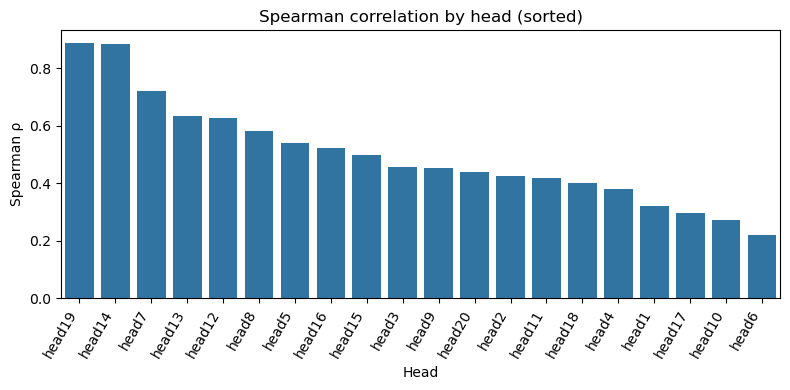

In [8]:
spear_list = []
for ax, head in zip(axes.ravel(), heads_list):
    x, y = final_df[head].to_numpy(), final_df["contact_map"].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)
    spear_list.append((f"{head}", rho))
    # print(f"{head}\n ρ={rho:.2f}, p={p:.1e}, n={len(x)}")
sorted_list = sorted(spear_list, key=lambda t: t[1], reverse = True)
ys = [y[1] for y in sorted_list]
xs = [x[0] for x in sorted_list]

plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)  # use ci=None if older seaborn
ax.set_ylabel("Spearman ρ")
ax.set_xlabel("Head")
ax.set_title("Spearman correlation by head (sorted)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

### P@L vs pPLL

In [9]:
xcol = "pseudo_perplexity"
ycols = ["contact_map"] + [f"head{i}" for i in range(1, 21)]

# cover NaNs
work = final_df[[xcol] + ycols].replace([np.inf, -np.inf], np.nan)

rows = []
for y in ycols:
    s = work[[xcol, y]].dropna()
    rho, p = spearmanr(s[xcol], s[y])
    rows.append({"metric": y, "n": len(s), "spearman_rho": rho})

corr_df = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
print(corr_df.to_string(index=False))

     metric    n  spearman_rho
     head16 3532      0.270926
     head18 3532      0.169459
      head9 3532      0.157323
     head20 3532      0.118612
     head15 3532      0.114872
     head12 3532      0.083118
      head3 3532      0.035205
      head2 3532      0.033208
contact_map 3532      0.021107
     head13 3532      0.017357
      head7 3532     -0.009362
      head6 3532     -0.013330
     head14 3532     -0.034291
     head10 3532     -0.050699
     head19 3532     -0.056100
     head17 3532     -0.086520
      head5 3532     -0.087900
      head1 3532     -0.099722
      head4 3532     -0.104513
      head8 3532     -0.114241
     head11 3532     -0.217367


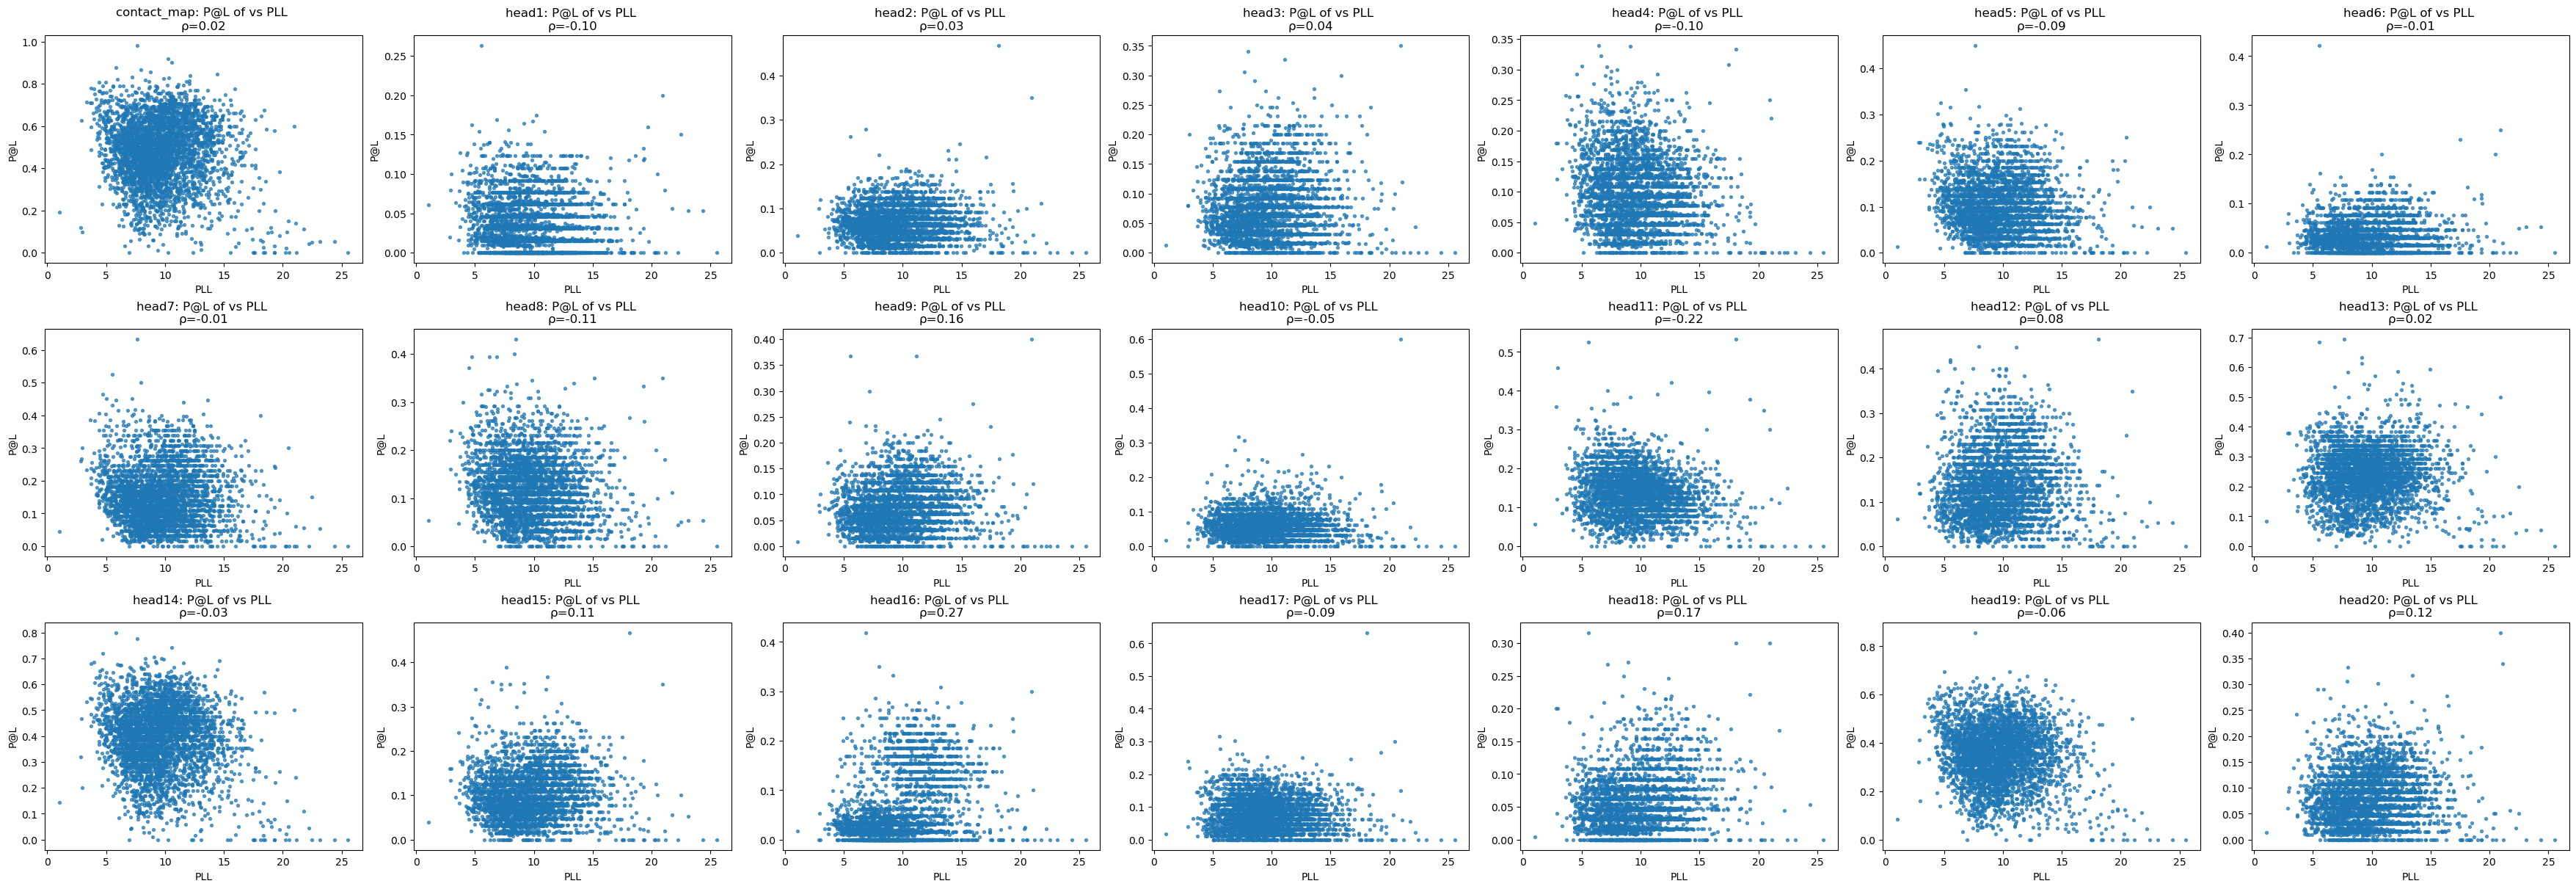

In [7]:
ycols = ["contact_map"] + [f"head{i}" for i in range(1, 21)]
nplots = len(ycols)
ncols = 7
nrows = ceil(nplots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, attn in zip(axes.ravel(), ycols):
    x, y = final_df["pseudo_perplexity"].to_numpy(), final_df[attn].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    ax.set_title(f"{attn}: P@L of vs PLL \nρ={rho:.2f}")#, p={p:.1e}, n={len(x)}")
    ax.set_xlabel("PLL")
    ax.set_ylabel("P@L")

for ax in axes.ravel()[len(ycols):]:
    ax.axis("off")

plt.show()

/work3/s232958/tmp/ipykernel_2832329/1961181223.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


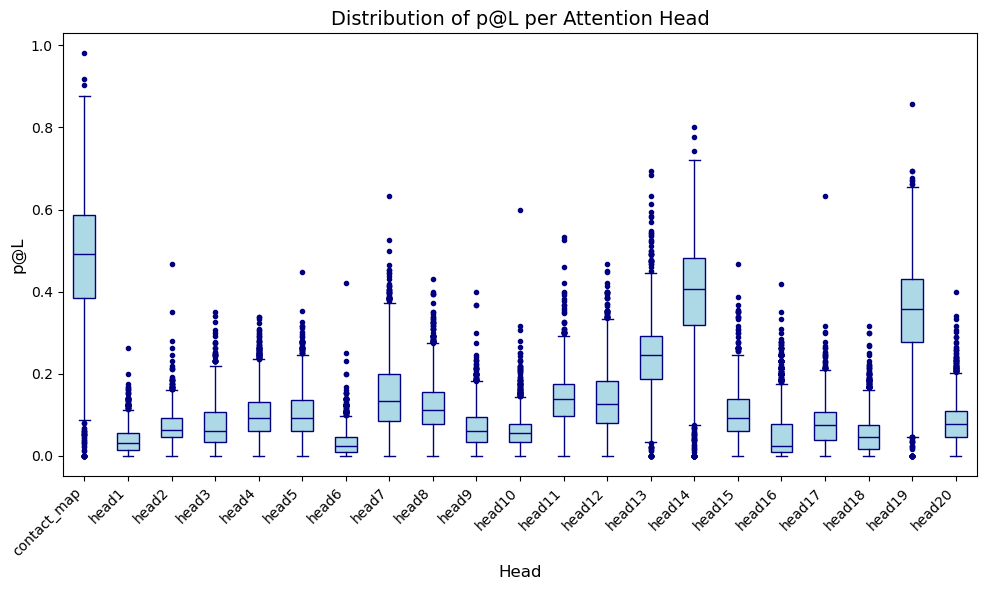

In [15]:
# Select all head columns
head_cols = [col for col in final_df.columns if col.startswith("head") or col.startswith("contact_map")]

# Melt to long format (optional but clean)
long_df = final_df[head_cols].melt(var_name="head", value_name="p_at_L")

plt.figure(figsize=(10,6))

# Boxplot with blue color
box = plt.boxplot(
    [long_df[long_df["head"] == h]["p_at_L"].dropna() for h in head_cols],
    labels=head_cols,
    patch_artist=True,   # allows coloring boxes
    boxprops=dict(facecolor='lightblue', color='navy'),
    capprops=dict(color='navy'),
    whiskerprops=dict(color='navy'),
    flierprops=dict(markerfacecolor='navy', markeredgecolor='navy', markersize=3),
    medianprops=dict(color='navy')
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("p@L", fontsize=12)
plt.xlabel("Head", fontsize=12)
plt.title("Distribution of p@L per Attention Head", fontsize=14)
plt.tight_layout()
plt.show()

### P@L vs avergae log-likelihood

     metric    n  spearman_rho
     head11 3532      0.217367
      head8 3532      0.114241
      head4 3532      0.104513
      head1 3532      0.099722
      head5 3532      0.087900
     head17 3532      0.086520
     head19 3532      0.056100
     head10 3532      0.050699
     head14 3532      0.034291
      head6 3532      0.013330
      head7 3532      0.009362
     head13 3532     -0.017357
contact_map 3532     -0.021107
      head2 3532     -0.033208
      head3 3532     -0.035205
     head12 3532     -0.083118
     head15 3532     -0.114872
     head20 3532     -0.118612
      head9 3532     -0.157323
     head18 3532     -0.169459
     head16 3532     -0.270926



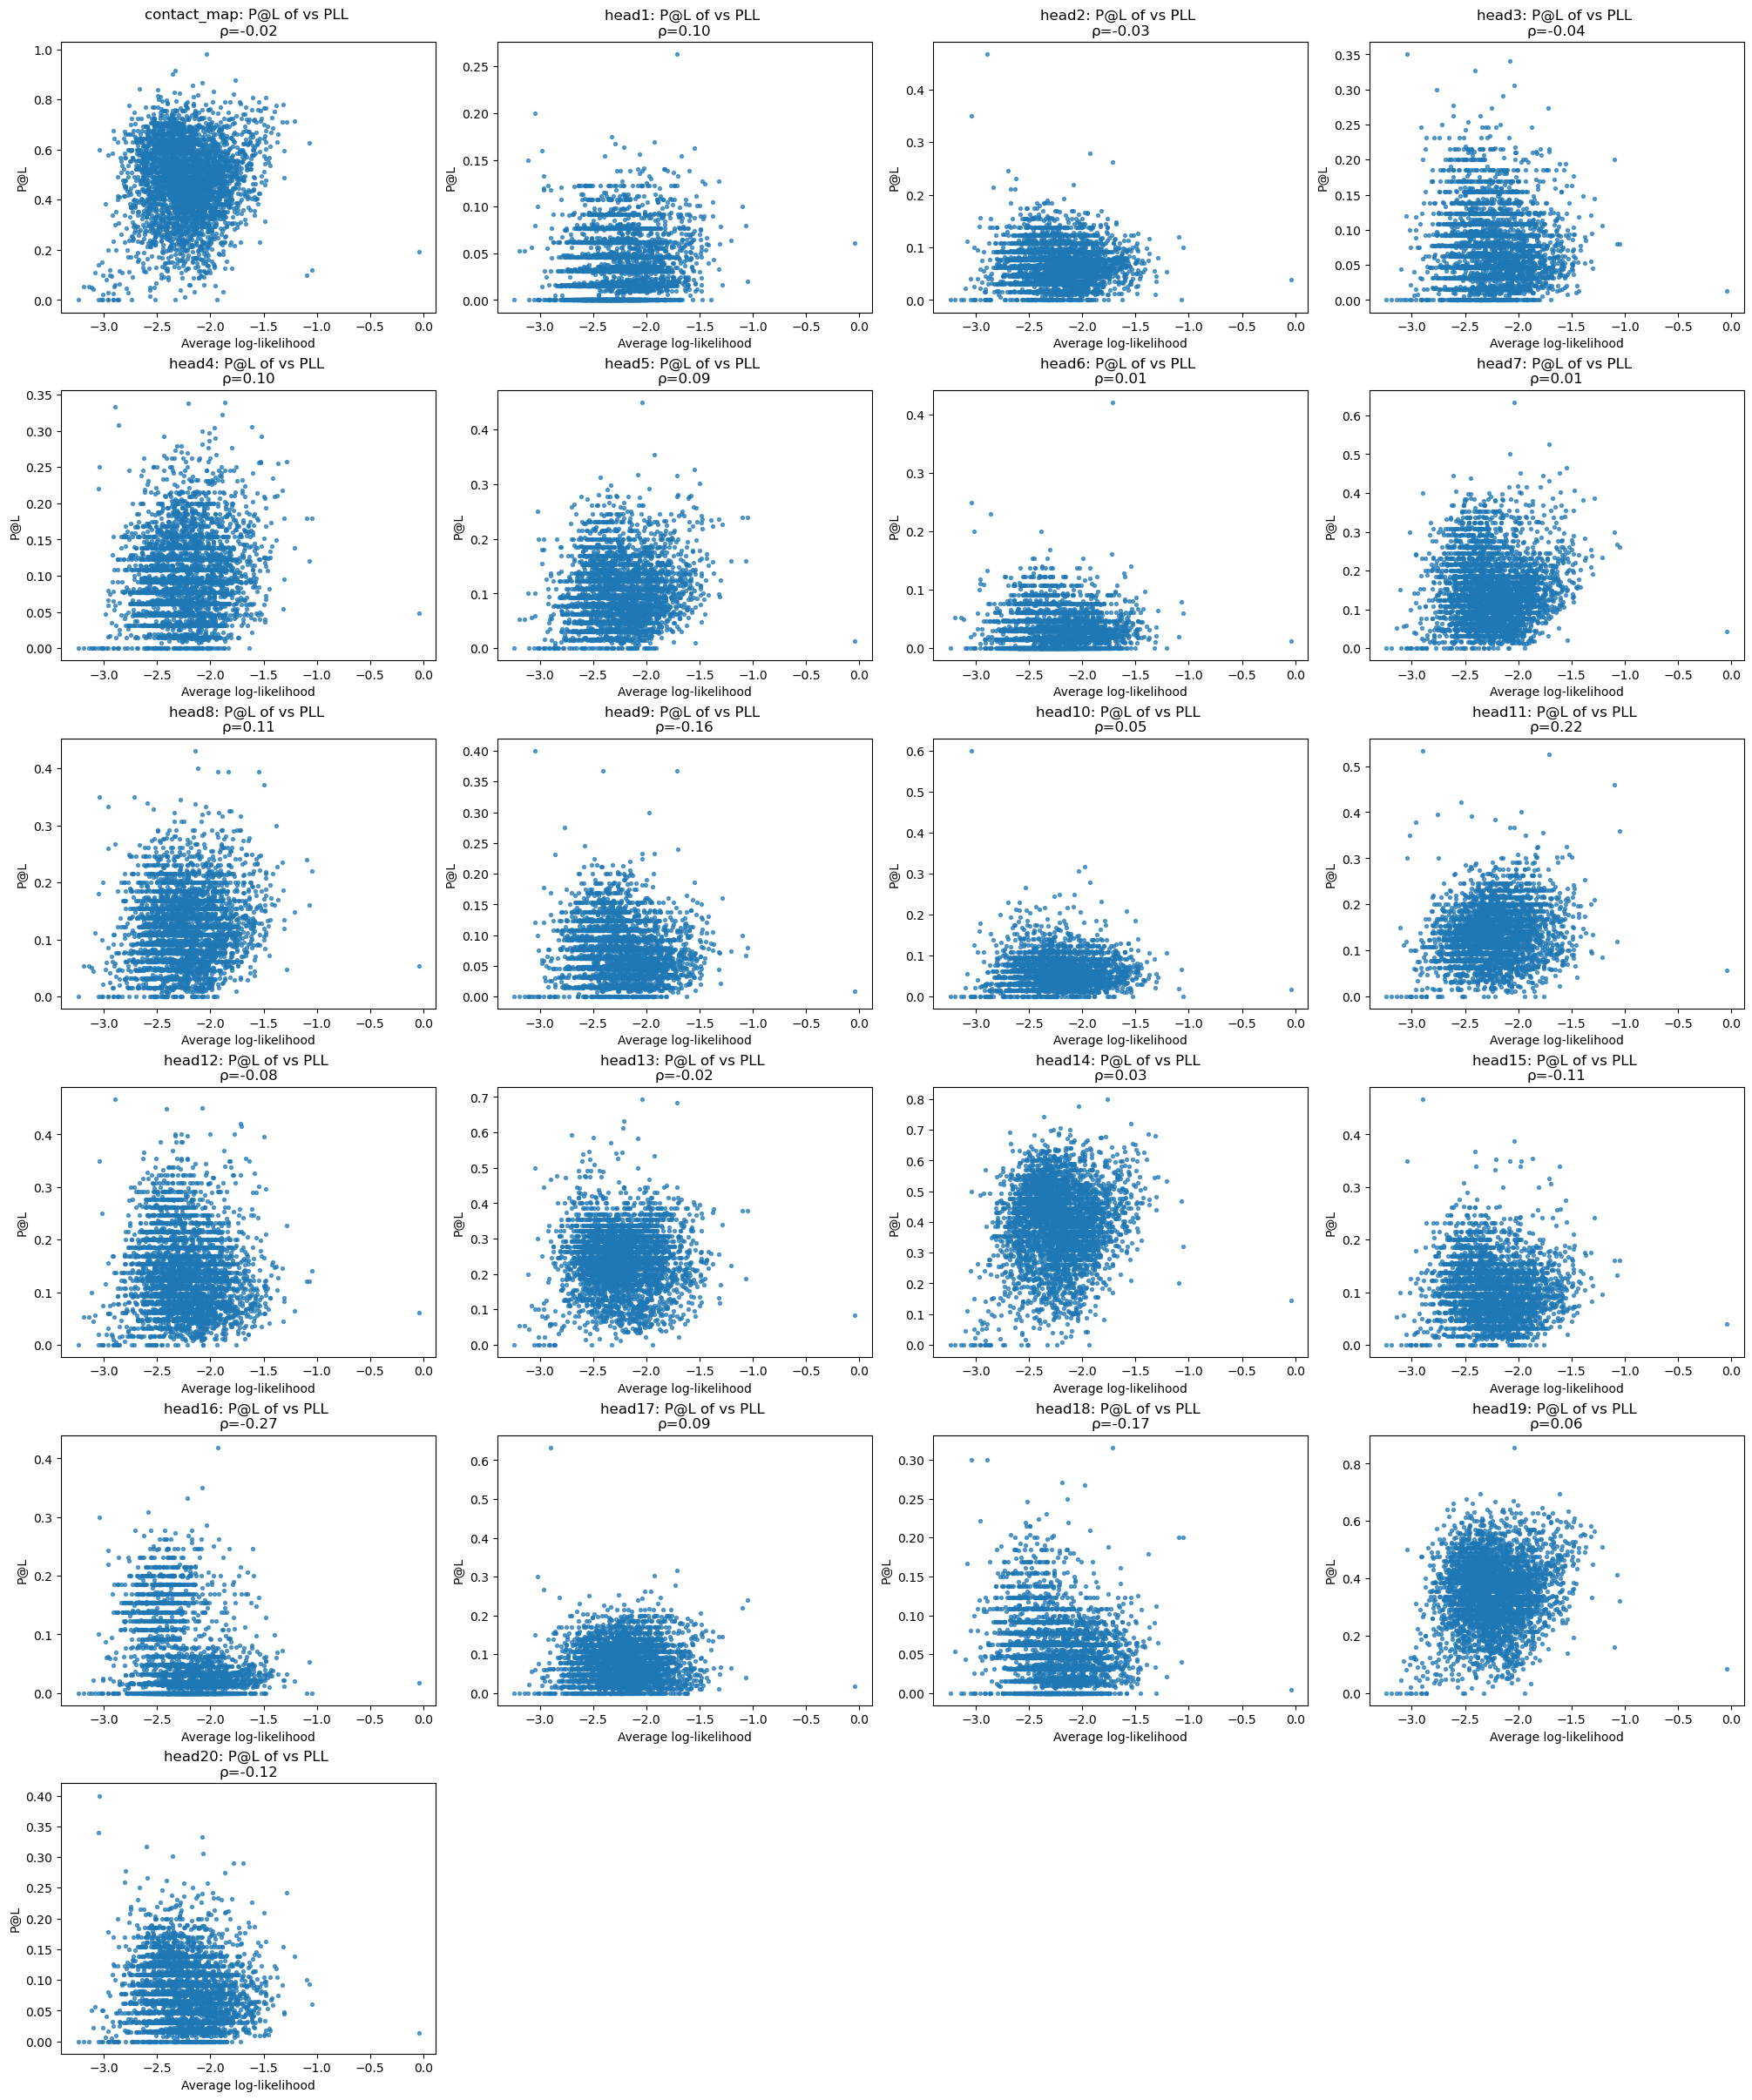

In [27]:
xcol = "avg_log_likelihood"
ycols = ["contact_map"] + [f"head{i}" for i in range(1, 21)]

# cover NaNs
work = final_df[[xcol] + ycols].replace([np.inf, -np.inf], np.nan)

rows = []
for y in ycols:
    s = work[[xcol, y]].dropna()
    rho, p = spearmanr(s[xcol], s[y])
    rows.append({"metric": y, "n": len(s), "spearman_rho": rho})

corr_df = pd.DataFrame(rows).sort_values("spearman_rho", ascending=False)
print(corr_df.to_string(index=False))
print("")

ycols = ["contact_map"] + [f"head{i}" for i in range(1, 21)]
nplots = len(ycols)
ncols = 4
nrows = ceil(nplots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), constrained_layout=True)
axes = np.array(axes).reshape(nrows, ncols)

for ax, attn in zip(axes.ravel(), ycols):
    x, y = final_df["avg_log_likelihood"].to_numpy(), final_df[attn].to_numpy()

    # mask NaNs (where some cause binders are short an minimal sequence distance was used 24)
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # spearman correlation
    rho, p = spearmanr(x, y)

    # plotting
    ax.scatter(x, y, s=8, alpha=0.7)
    ax.set_title(f"{attn}: P@L of vs PLL \nρ={rho:.2f}")#, p={p:.1e}, n={len(x)}")
    ax.set_xlabel("Average log-likelihood")
    ax.set_ylabel("P@L")

for ax in axes.ravel()[len(ycols):]:
    ax.axis("off")

plt.show()

**Take away:** 
1) there’s no clear monotonic relationship between how probable the sequence looks to your language model (PLL) and how accurate your contact predictions are.
2) **sensitive model** - low PLL points have high P@L, while high PLL points have low P@L - precission of the model is highly depended on the encoding (PLL)
3) **robust model** - P@L is not that depended on the PLL - slightly inaccurate encodings will not affect model's performance that much.

### Length (L): longer sequences tend to have lower P@L (harder task) and different PLL ranges.

In [15]:
patLs_PLLs_df

target_id                                         binder_seq  \
0        VirB8  DVEEAERLAKELGDPDILEALKELKERLKKGDPEAEEIIKLLSELL...   
1        VirB8  DLIERLIKIARELGDEEAVRLLEKALEALKRGDYETVLKLLREVYK...   
2        VirB8  SEELIETIKELLKRVPDPRVRELARKALKLAEELGDPELLKLLKTC...   
3        VirB8  DLSERVLKAIALAVKLGNEVLFKAQIILCSITLGVPPEECLKLAKE...   
4        VirB8  DEERLRRLGVPPEVVELLKRLYRELEKQGIPPEAIVAYLYVIAVEL...   
...        ...                                                ...   
3478      EGFR  DRLEELIKLLLEDPNDEEVLEELEKLFEEALENGDPDLAELATAVY...   
3479      EGFR  SERAKEILRELIEKIPTPVVRHLLRLLEEALERGNPQLLEQLLMML...   
3480      EGFR  GEYRRWEFRYEAEDEEWLRHRVRENLERARRFAEELNRRGLDAKVQ...   
3481      EGFR  DVEEKLELLKELLKKLNSPLAREILELIEELRKRLDPREVIFIVFA...   
3482      EGFR  SLELMIKQLKMFLKELGDPDVLKVVERLEERLKRGDPEAERLLMEL...   

                                             target_seq  binder_pll binder_id  \
0     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...    7.716662  VirB8_58   
1     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...    7.112997  VirB8_30   
2     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...    9.240036  VirB8_64   
3     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...    9.672145  VirB8_17   
4     ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...    7.964080  VirB8_48   
...                                                 ...         ...       ...   
3478  RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...    7.116220   EGFR_50   
3479  RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...    8.121863   EGFR_51   
3480  RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...   10.686497   EGFR_44   
3481  RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...   11.216477   EGFR_90   
3482  RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGD...    8.269205   EGFR_76   

      contact_map  head1  head2  head3  head4  ...  head12  head13  head14  \
0           0.354  0.123  0.092  0.031  0.092  ...   0.123   0.308   0.308   
1           0.600  0.092  0.077  0.077  0.077  ...   0.292   0.308   0.446   
2           0.308  0.092  0.123  0.062  0.046  ...   0.092   0.231   0.215   
3           0.431  0.046  0.062  0.077  0.062  ...   0.231   0.308   0.338   
4           0.415  0.031  0.031  0.046  0.046  ...   0.046   0.246   0.369   
...           ...    ...    ...    ...    ...  ...     ...     ...     ...   
3478        0.569  0.046  0.092  0.062  0.185  ...   0.185   0.385   0.446   
3479        0.538  0.092  0.046  0.169  0.062  ...   0.185   0.246   0.415   
3480        0.569  0.031  0.031  0.031  0.138  ...   0.185   0.308   0.477   
3481        0.323  0.046  0.092  0.077  0.108  ...   0.123   0.246   0.262   
3482        0.400  0.015  0.108  0.077  0.077  ...   0.154   0.323   0.277   

      head15  head16  head17  head18  head19  head20  len_binder  
0      0.077   0.031   0.123   0.062   0.292   0.015          65  
1      0.077   0.046   0.123   0.062   0.415   0.015          65  
2      0.062   0.000   0.062   0.015   0.231   0.031          65  
3      0.108   0.000   0.123   0.000   0.369   0.154          65  
4      0.077   0.015   0.062   0.000   0.308   0.046          65  
...      ...     ...     ...     ...     ...     ...         ...  
3478   0.077   0.015   0.123   0.062   0.415   0.077          65  
3479   0.062   0.000   0.046   0.031   0.369   0.062          65  
3480   0.138   0.138   0.092   0.123   0.446   0.092          65  
3481   0.062   0.000   0.046   0.015   0.262   0.000          65  
3482   0.123   0.000   0.123   0.031   0.215   0.046          65  

[3483 rows x 27 columns]

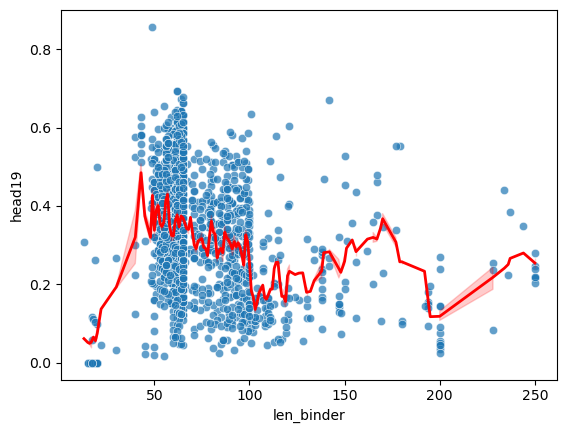

In [16]:
# Sort by x so rolling works left→right
df = patLs_PLLs_df.sort_values("len_binder").copy()
focus = "head19"

# Compute running mean over y (choose window size to taste)
WINDOW = 10  # try 20/50/100 depending on your data size
df["running_mean"] = (df[focus].rolling(window=WINDOW, min_periods=1, center=True).mean())

# Plot
ax = sns.scatterplot(data=patLs_PLLs_df, x="len_binder", y=focus, alpha=0.7)
sns.lineplot(data=df, x="len_binder", y="running_mean", linewidth=2, color="red", ax=ax)
plt.show()